In [1]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
# import get_full_info
from sklearn import linear_model as lm, metrics, ensemble as ens
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import warnings

2024-04-03 17:29:26.766177: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# df = get_full_info.df
# df.to_csv("full_info.csv", index = False)
df = pd.read_csv("full_info.csv")

# df_latest = get_full_info.df_realtime
# df_latest.to_csv("latest_years.csv", index = False)
df_latest = pd.read_csv("latest_years.csv")

In [3]:
df_opzones = pd.read_csv("opzone_list.csv")

In [4]:
df = pd.get_dummies(df, prefix = 'state', columns = ['state'])
df_latest = pd.get_dummies(df_latest, prefix = 'state', columns = ['state'])

In [5]:
for col in df.columns:
    if 'state' in col:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [6]:
df_latest = df_latest[df_latest['year'] == df_latest['year'].max()]

In [7]:
opzones = list(set(df_opzones['County'].values.tolist()))
opzones_formatted = [x for x in df_latest['place'] if any(y in x for y in opzones)]
df_latest = df_latest[df_latest['place'].isin(opzones_formatted)]

In [8]:
print('mean current value: ', df_latest['average_home_value'].mean())
print('median current value: ', df_latest['average_home_value'].median())
print('25th percentile current value: ', np.percentile(df_latest['average_home_value'], 25))
print('number 200k or less: ', len(df_latest[df_latest['average_home_value'] <= 200000]))

mean current value:  361946.5698018018
median current value:  302245.34
25th percentile current value:  236493.785
number 200k or less:  70


In [9]:
df_latest_candidates = df_latest.sort_values(by = 'average_home_value').drop(columns = [x for x in df_latest.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and \
                                                                                        # '3' not in x and\
                                        'roi' not in x and 'vacancy' not in x])

df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('California')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('New York')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Puerto Rico')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Hawaii')]
df_latest_candidates = df_latest_candidates[df_latest_candidates['average_home_value'] <= 250000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['total_population'] >= 100000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_1_years'] < 0]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_3_years'] < df_latest_candidates['vacancy_growth_last_2_years']]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_2_years'] < df_latest_candidates['vacancy_growth_last_1_years']] 
df_latest_candidates.sort_values(by = 'vacancy_rate')

,year,average_annual_rent,place,average_home_value,total_population,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years
4295,2022,10077.00,Webb County - Texas,214876.97,267780,0.066400,-0.274451,-0.312893,-0.398654
4177,2022,9995.76,Summit County - Ohio,243907.40,535882,0.067572,-0.057368,-0.144442,-0.237275
4172,2022,9986.76,Montgomery County - Ohio,208866.70,533892,0.068186,-0.320557,-0.375939,-0.425148
3954,2022,9650.40,Black Hawk County - Iowa,214102.22,130274,0.071951,-0.130795,-0.139619,-0.361561
4218,2022,8984.28,Erie County - Pennsylvania,206149.49,267689,0.073566,-0.059963,-0.202974,-0.235928
3930,2022,9316.92,Madison County - Illinois,230026.84,263864,0.076456,-0.003611,-0.185406,-0.231434
3942,2022,8528.40,Delaware County - Indiana,160351.62,112031,0.080454,-0.258178,-0.298912,-0.400547
4019,2022,9311.88,Jackson County - Michigan,218947.34,160066,0.086192,-0.179692,-0.199089,-0.284876
3975,2022,10338.12,Bossier Parish - Louisiana,243277.00,129276,0.097280,-0.176416,-0.295024,-0.338428
4296,2022,9778.08,Wichita County - Texas,184143.64,129978,0.099112,-0.161077,-0.261678,-0.293045


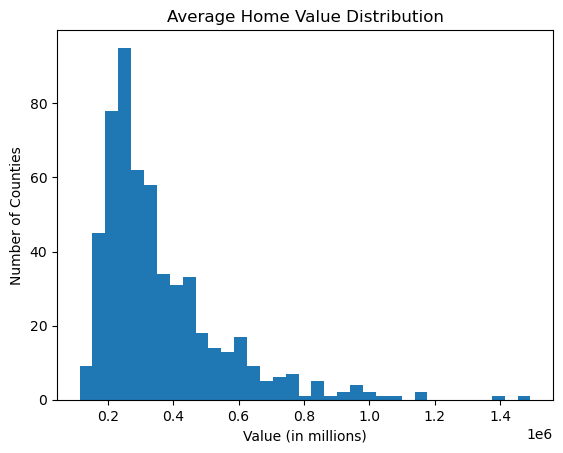

In [10]:
plt.hist(df_latest['average_home_value'], bins = 35)
plt.title("Average Home Value Distribution")
plt.xlabel("Value (in millions)")
plt.ylabel("Number of Counties")
plt.savefig("Home_Values_Dist")

In [11]:
df_latest['vacancy_rate'].mean()

0.09232452947995137

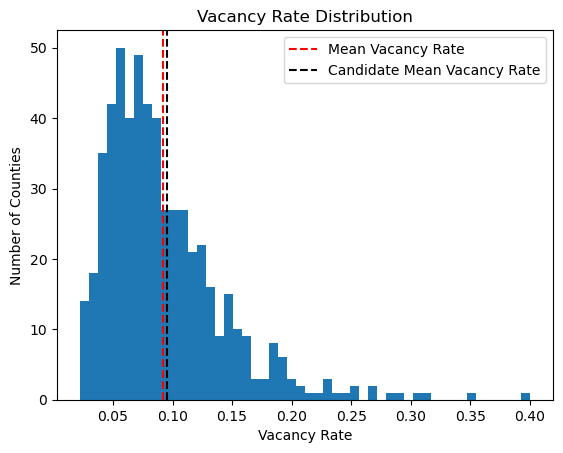

In [12]:
plt.hist(df_latest['vacancy_rate'], bins = 50)
plt.axvline(df_latest['vacancy_rate'].mean(), color = 'r', linestyle = 'dashed', label = 'Mean Vacancy Rate')
plt.axvline(df_latest_candidates['vacancy_rate'].mean(), color = 'k', linestyle = 'dashed', label = 'Candidate Mean Vacancy Rate')
plt.legend()
plt.title("Vacancy Rate Distribution")
plt.xlabel("Vacancy Rate")
plt.ylabel("Number of Counties")
plt.savefig("Vacancy_Dist")

In [13]:
print('mean current vacancy rate: ', df_latest['vacancy_rate'].mean())
print('median current vacancy rate: ', df_latest['vacancy_rate'].median())
print('25th percentile current vacancy rate: ', np.percentile(df_latest['vacancy_rate'], 25))


mean current vacancy rate:  0.09232452947995137
median current vacancy rate:  0.0802365539838567
25th percentile current vacancy rate:  0.05640196145241215


(array([ 7.,  6., 11.,  6., 17., 14., 16., 21., 25., 20., 22., 19., 23.,
        16., 25., 16., 25., 21., 14., 13., 12., 20.,  7., 13., 11., 17.,
         9.,  8.,  6., 14.,  6.,  9.,  3.,  5.,  9.,  7.,  4.,  6.,  2.,
         5.,  3.,  2.,  1.,  2.,  2.,  4.,  3.,  3.,  3.,  3.]),
 array([0.02199413, 0.02553192, 0.0290697 , 0.03260749, 0.03614527,
        0.03968305, 0.04322084, 0.04675862, 0.05029641, 0.05383419,
        0.05737197, 0.06090976, 0.06444754, 0.06798533, 0.07152311,
        0.07506089, 0.07859868, 0.08213646, 0.08567425, 0.08921203,
        0.09274981, 0.0962876 , 0.09982538, 0.10336317, 0.10690095,
        0.11043873, 0.11397652, 0.1175143 , 0.12105209, 0.12458987,
        0.12812765, 0.13166544, 0.13520322, 0.13874101, 0.14227879,
        0.14581657, 0.14935436, 0.15289214, 0.15642993, 0.15996771,
        0.16350549, 0.16704328, 0.17058106, 0.17411885, 0.17765663,
        0.18119441, 0.1847322 , 0.18826998, 0.19180777, 0.19534555,
        0.19888333]),
 <BarContainer

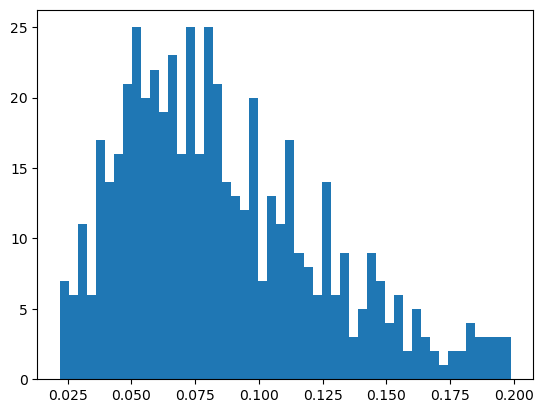

In [14]:
plt.hist(df_latest[df_latest['vacancy_rate'] < 0.2]['vacancy_rate'], bins = 50)

In [15]:
# MAKE VALI DATA SECOND TO LAST YEAR; TEST DATA LAST YEAR; TRAIN FIRST 6
last_year = df['year'].max()
train = df[df['year'] < last_year - 4]
vali = df[df['year'] == last_year - 1]
test = df[df['year'] == last_year]

In [16]:
print('training sample - ', len(train))
print('validation sample - ', len(vali))
print('test sample - ', len(test))

training sample -  4209
validation sample -  578
test sample -  523


In [17]:
# SCALE NON-PERCENTAGES
std_scl = StandardScaler()

In [18]:
#X, Y SPLITS
ex_train = train.drop(columns = ['year', 'place', 'roi'])
ex_train_scaled = std_scl.fit_transform(ex_train)
why_train = train['roi']


ex_vali = vali.drop(columns = ['year', 'place', 'roi'])
ex_vali_scaled = std_scl.fit_transform(ex_vali)
why_vali = vali['roi']

ex_test = test.drop(columns = ['year', 'place', 'roi'])
ex_test_scaled = std_scl.fit_transform(ex_test)
why_test = test['roi']

LET'S SET SOME "DUMB" BASELINES; A VERY SIMPLE MODEL AND STANDARD DEV (THIS ONE SHOULD BE HARDER SINCE WE DON'T KNOW AVERAGE OF POPULATION BEFOREHAND)

In [19]:
mse = metrics.mean_squared_error
mae = metrics.mean_absolute_error

In [20]:
print('actuals mean - ', why_vali.mean())
print('actuals standard dev - ', why_vali.std())

actuals mean -  0.3207628027681661
actuals standard dev -  0.10560311174465994


In [21]:
vali['average_home_value'] = vali['average_home_value'].astype('float')
vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
vali['average_annual_rent'] = vali['average_annual_rent'].astype('float')
vali['rent_growth_last_1_years'] = vali['rent_growth_last_1_years'].astype('float')
vali['rent_growth_last_2_years'] = vali['rent_growth_last_2_years'].astype('float')
vali['rent_growth_last_3_years'] = vali['rent_growth_last_3_years'].astype('float')


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_99122/939463968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['average_home_value'] = vali['average_home_value'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_99122/939463968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['home_val_growth_last_3_years'] = vali['home_val_growth_last_3_years'].astype('float')
/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_99122/939463968.py:3: SettingWithCo

In [22]:
vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_99122/1132831924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \


In [23]:
print('rmse - ', m.sqrt(mse(why_vali, vali['fake_pred'])))
print('mae - ', mae(why_vali, vali['fake_pred']))
vali = vali.drop(columns = ['fake_pred'])

rmse -  0.14113251644193067
mae -  0.10913875432525952


START W/ OUT OF THE BOX PREDICTIONS

In [24]:
rf = ens.RandomForestRegressor()
# TRAIN/VALI
rf_fit = rf.fit(ex_train, why_train)
rf_preds = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds)))
print('mae - ', mae(why_vali, rf_preds))

# # PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds = rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds)))
print('training mae - ', mae(why_train, rf_train_preds))

rmse -  0.12736225800433165
mae -  0.09791674740484431
training rmse -  0.032492849025651076
training mae -  0.02318379425041578


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_99122/3620537912.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

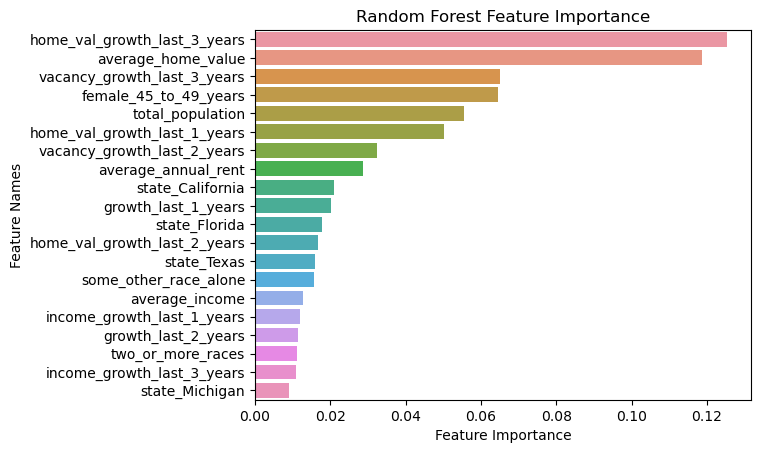

In [25]:
feature_names = ex_train.columns
importances = rf_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
rf_df = pd.DataFrame(data)
rf_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
rf_df = rf_df.head(20)

sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

VERSUS HYPERPARAMATER TUNED

In [26]:
%store -r rf_params

In [27]:
rf_params

{'rf__n_estimators': 50,
 'rf__max_depth': 30,
 'rf__criterion': 'friedman_mse',
 'pca__n_components': 18}

In [28]:
steps = [('pca', PCA(n_components = rf_params['pca__n_components'])), 
         ('rf', ens.RandomForestRegressor(n_estimators = rf_params['rf__n_estimators'], 
                                      max_depth = rf_params['rf__max_depth'],
                                      criterion = rf_params['rf__criterion']))]
model_rf = Pipeline(steps = steps)

# TRAIN/VALI
rf_fit = model_rf.fit(ex_train, why_train)
rf_preds_tuned = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds_tuned)))
print('mae - ', mae(why_vali, rf_preds_tuned))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds_tuned = model_rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds_tuned)))
print('training mae - ', mae(why_train, rf_train_preds_tuned))

rmse -  0.15196440091311272
mae -  0.11854797436375908
training rmse -  0.04652349645678227
training mae -  0.03340987576125787


In [29]:
%store -r ada_params

In [30]:
ada_params

{'n_estimators': 150, 'learning_rate': 1}

In [31]:
ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], learning_rate = ada_params['learning_rate'])
# TRAIN/VALI
ada_fit = ada.fit(ex_train, why_train)
ada_preds = ada_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, ada_preds)))
print('mae - ', mae(why_vali, ada_preds))
               
# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
ada_train_preds = ada.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, ada_train_preds)))
print('training mae - ', mae(why_train, ada_train_preds))

rmse -  0.1342287552896777
mae -  0.10321838155201482
training rmse -  0.10351018268908993
training mae -  0.0833927842647148


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_99122/3200975213.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

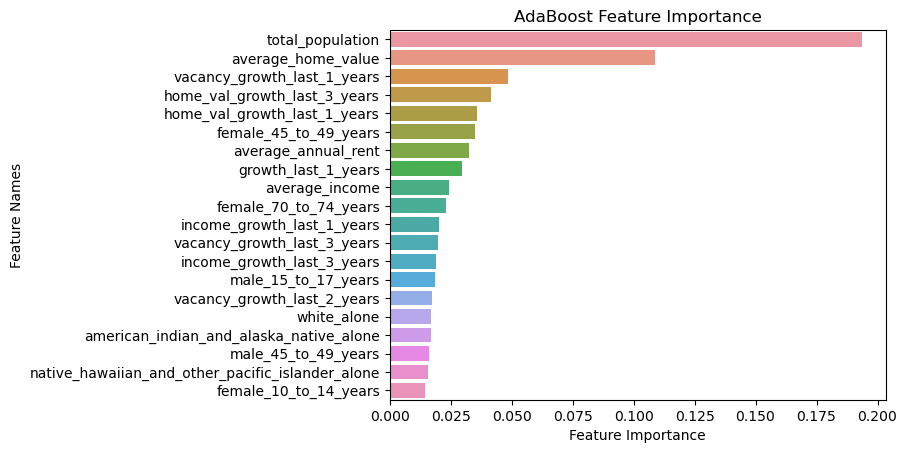

In [32]:
feature_names = ex_train.columns
importances = ada_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
ada_df = pd.DataFrame(data)
ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
ada_df = ada_df.head(20)

sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('AdaBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [33]:
%store -r xgboost_params

In [34]:
xgboost_params

{'scale_pos_weight': 1, 'max_depth': 7, 'eta': 0.1}

In [35]:
# XGBOOST IS BEING A CRYBABY ABOUT TYPES IDK WHY, BUT WHATEVER I'LL EXPLICITLY FIX LOL
ex_train['average_annual_rent'] = ex_train['average_annual_rent'].astype(float)
ex_train['average_home_value'] = ex_train['average_home_value'].astype(float)
ex_train['average_income'] = ex_train['average_income'].astype(float)

ex_vali['average_annual_rent'] = ex_vali['average_annual_rent'].astype(float)
ex_vali['average_home_value'] = ex_vali['average_home_value'].astype(float)
ex_vali['average_income'] = ex_vali['average_income'].astype(float)


xg = XGBRegressor(scale_pos_weight = xgboost_params['scale_pos_weight'],
                  max_depth = xgboost_params['max_depth'], 
                  eta = xgboost_params['eta'])

# TRAIN/VALI
xg_fit = xg.fit(ex_train, why_train)
xg_preds = xg_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, xg_preds)))
print('mae - ', mae(why_vali, xg_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
xg_train_preds = xg.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, xg_train_preds)))
print('training mae - ', mae(why_train, xg_train_preds))

rmse -  0.1276655052827606
mae -  0.0987544901237562
training rmse -  0.02920138160346676
training mae -  0.02210653317178532


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_99122/1849121513.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

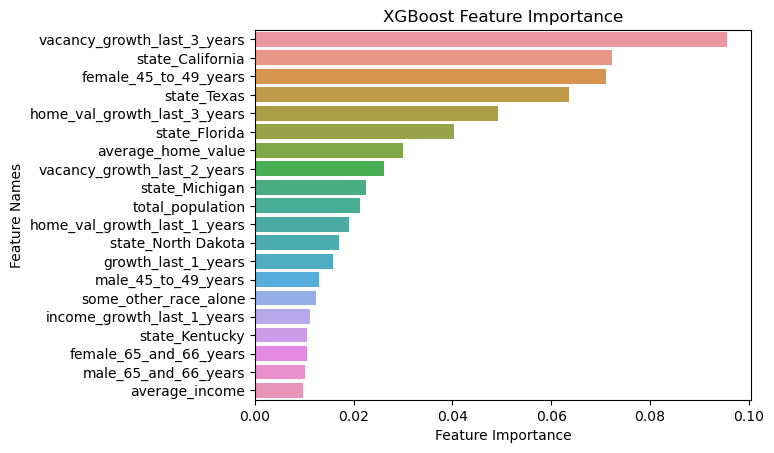

In [36]:
feature_names = ex_train.columns
importances = xg_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
xg_df = pd.DataFrame(data)
xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
xg_df = xg_df.head(20)

sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
# plt.savefig("adaboost_fi_diag_chrom_level", bbox_inches = "tight")

In [37]:
# SO MODEL PERFORMANCE NOT GREAT, BUT I WANNA SEE WHAT THE TOP PREDICTED AREAS WERE FOR FUN
# AFTER ALL, IF IT'S TYPICALLY OFF BUT THE VERY HIGH PREDS ARE MORE SOLID, THEN THIS ACTUALLY IS STILL USEFUL
# SINCE OUR GOAL IS TO USE THIS TO IDENTIFY TOP CANDIDATES
# RF WAS MOST PERFORMANT SO GOING TO BASE THIS ON THOSE PREDS

vali['predicted_roi'] = rf_preds

In [38]:
pred_check = vali.sort_values(by = 'predicted_roi', ascending = False)
pred_check = pred_check.drop(columns = [x for x in df.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and\
                                        'roi' not in x])


In [39]:
df_ec = vali.copy()
df_ec['error'] = round(df_ec['predicted_roi'] - df_ec['roi'], 3)

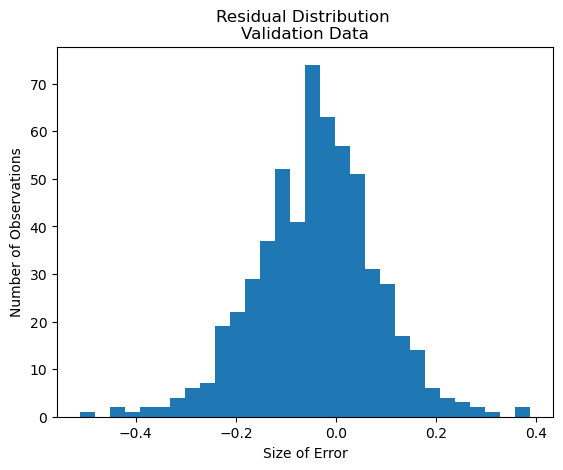

In [40]:
plt.hist(df_ec['error'], bins = 30)
plt.title("Residual Distribution \nValidation Data")
plt.xlabel("Size of Error")
plt.ylabel("Number of Observations")
plt.savefig("Model_Residuals")

CHECKING IN, NONE OF THE MODELS (OFF THE SHELF OR TUNED) ACTUALLY BEAT THE STANDARD DEVIATION OF THE VALIDATION SET'S ROI. THIS MEANS NONE DOES BETTER THAN PREDICTING THE SET'S AVERAGE (THIS IS HARDER THAN IT SOUNDS AS WE DON'T HAVE THE AVERAGE AHEAD OF TIME). THIS LEADS ME TO CONCLUDE THE MODELS ARE OK IF IMPERFECT. THIS SEEMS TO BE IN LINE WITH THE MODEL ERROR BEING FAIRLY NORMAL BUT NOT QUITE ABOUT ZERO.

NEXT, WE CHECK WITH A MORE "REAL WORLD" TEST. REALISTICALLY WE WOULD NOT BE BUYING AND SHORTING ON EVERY CITY'S REAL ESTATE MARKET, SO THE BETTER APPLICATION IS TO SEE WHAT WOULD HAVE HAPPENED IF WE HAD USED THE MODEL TO IDENTIFY TOP CANDIDATES IN THE LATEST YEAR OF TESTABLE DATA. I CONSIDER ANY CANDIDATE IDENTIFIED THAT WOULD HAVE PERFORMED BETTER THAN AVERAGE ACCEPTABLE (THRESHOLD IN CELL BELOW).

In [41]:
print('predicted roi mean - ', pred_check['predicted_roi'].mean())
print('roi mean - ', pred_check['roi'].mean())

predicted roi mean -  0.28136301038062284
roi mean -  0.3207628027681661


In [42]:
opzones = list(set(df_opzones['County'].values.tolist()))
opzones_formatted = [x for x in pred_check['place'] if any(y in x for y in opzones)]
pred_check = pred_check[pred_check['place'].isin(opzones_formatted)]

In [43]:
pred_check.head(25)

,year,average_annual_rent,place,average_home_value,total_population,roi,predicted_roi
6035,2018,27701.04,San Mateo County - California,1318971.20,769545,0.1360,0.523967
6040,2018,18206.76,Solano County - California,490925.18,446610,0.2781,0.519047
6526,2018,16922.16,Snohomish County - Washington,506140.29,814901,0.3930,0.513436
6016,2018,21740.16,Alameda County - California,921760.47,1666753,0.2079,0.490998
6264,2018,12342.72,Clark County - Nevada,333128.50,2231647,0.3857,0.479791
6037,2018,26148.36,Santa Clara County - California,1207587.98,1937570,0.1606,0.478280
6403,2018,15544.08,Washington County - Oregon,457766.69,597695,0.2991,0.472102
6265,2018,12799.80,Washoe County - Nevada,429330.28,465735,0.3817,0.470671
6074,2018,13158.84,Hillsborough County - Florida,289578.33,1436888,0.4158,0.466939
6078,2018,13702.44,Manatee County - Florida,308108.90,394855,0.3612,0.459794


In [44]:
pred_check.sort_values(by = 'roi', ascending = False).head(25)

,year,average_annual_rent,place,average_home_value,total_population,roi,predicted_roi
6111,2018,8761.68,Canyon County - Idaho,227374.39,223499,0.8293,0.317578
6094,2018,9575.40,Clayton County - Georgia,135140.46,289615,0.7434,0.296588
6259,2018,9910.56,Missoula County - Montana,333839.85,118791,0.6949,0.289261
6109,2018,11600.04,Ada County - Idaho,340598.30,469966,0.6685,0.378854
6518,2018,11050.32,Clallam County - Washington,308602.33,76737,0.6463,0.320759
6504,2018,10380.48,Weber County - Utah,275991.40,256359,0.6456,0.382187
6073,2018,10872.96,Hernando County - Florida,172689.38,190865,0.6291,0.391405
6112,2018,11489.88,Kootenai County - Idaho,342809.76,161505,0.6086,0.401261
6052,2018,10084.80,Mesa County - Colorado,273871.14,153207,0.6059,0.181244
6509,2018,9790.44,Rockingham County - Virginia,247505.57,81244,0.5910,0.266702


In [45]:
[place for place in pred_check.head(25)['place'].values.tolist() if \
 place in pred_check.sort_values(by = 'roi', ascending = False).head(25)['place'].values.tolist()]

[]

SO, 6 OUT OF 25 OF THE TOP IDENTIFIED CANDIDATES WOULD HAVE PERFORMED WORSE THAN AVERAGE, 6 OF THE TOP 25 PERFORMERS WOULD HAVE HAD BELOW AVERAGE PREDICTIONS, AND 1 COUNTY WOULD HAVE BEEN TOP 25 IN EACH. USING THIS TEST OF THE MODEL IT IS CLEAR THAT IT CAN BE USEFUL (THE MAJORITY OF ITS TOP PREDICTIONS WOULD HAVE BEEN ABOVE AVERAGE, AND THE MAJORITY OF THE TOP PERFORMERS WOULD HAVE BEEN PREDICTED ABOVE AVERAGE) BUT WOULD HAVE TO BE USED WITH GREAT CAUTION IN A REAL-WORLD INVESTMENT SETTING, GIVEN THAT ROUGHLY A QUARTER OF THE TIME ITS RECOMMENDATION WOULD HAVE DONE QUITE POORLY.

In [46]:
ex_total = pd.concat([pd.concat([ex_train, ex_vali]), ex_test])
why_total = pd.concat([pd.concat([why_train, why_vali]), why_test])

In [47]:
df_latest = df_latest.dropna()
ex_serving = df_latest.drop(columns = ['year', 'place'])
ex_serving_scaled = std_scl.fit_transform(ex_serving)

In [48]:
rf_serve = rf.fit(ex_total, why_total)
rf_preds = rf_serve.predict(ex_serving)

In [49]:
df_latest['pred'] = rf_preds

In [50]:
# MAKE PLACE EASIER FOR API I.E. NO SPACES; WANNA KEEP IN ORIGINAL DF IN CASE I WANT FURTHER ANALYSIS
df_save = df_latest.copy()
df_save['place'] = df_save['place'].apply(lambda x: re.sub(' ', '.', 
                                                           re.sub('St.', 'Saint', 
                                                                  re.sub(' - ', '.', x))))

In [51]:
# NO NEED TO KEEP STATE DUMMIES FOR API; STATE ALREADY HUMAN-READABLE WITH PLACE COLUMN
df_save = df_save.drop(columns = [x for x in df_save.columns if 'state_' in x])

In [56]:
df_save.to_csv("latest_yrs_w_preds_county.csv", index = False)